In [1]:
!python -m spacy download en_core_web_lg

import pandas as pd
import spacy 
nlp=spacy.load("en_core_web_lg")

2023-05-22 05:46:56.074587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 05:46:57.056317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
df=pd.read_json("/content/news_dataset.json")
df.head(5)

,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [3]:
df["category"].shape

(7500,)

In [4]:
df["category"].value_counts()

CRIME       2500
SPORTS      2500
BUSINESS    2500
Name: category, dtype: int64

In [5]:
df["category_num"]=df["category"].map({"CRIME":0,"SPORTS":1,"BUSINESS":2})
df.head(5)

,text,category,category_num
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1
3,This Richard Sherman Interception Literally Sh...,SPORTS,1
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2


In [21]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [22]:
df["preprocessed_data"]=df["text"].apply(lambda text:preprocess(text))

In [24]:
df.head(5)

,text,category,category_num,preprocessed_data,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
df['vector'] = df['preprocessed_data'].apply(lambda text: nlp(text).vector)
df.head(5)

,text,category,category_num,preprocessed_data,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...,"[-0.5585511, -0.29323253, -0.9253956, 0.189389..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse,"[-0.73039824, -0.43196002, -1.2930516, -1.0628..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...,"[-1.9413117, 0.121578515, -3.2996283, 1.511650..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...,"[-1.4702771, -0.685319, 0.57398, -0.31135806, ..."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz,"[-1.037173, -1.9495698, -1.7179357, 1.2975286,..."


In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df.vector,df.category_num,random_state=42,test_size=0.2)

In [29]:
import numpy as np
print('X_train shape', X_train.shape)
print('X_test shape' , X_test.shape)

X_train shape (6000,)
X_test shape (1500,)


In [30]:
x_2d_train=np.stack(X_train)
x_2d_test=np.stack(X_test)
print('X_2d_train shape', x_2d_train.shape)
print('X_2d_test shape' , x_2d_test.shape)

X_2d_train shape (6000, 300)
X_2d_test shape (1500, 300)


use spacy glove embeddings for text vectorization.

use Decision Tree as the classifier.

In [31]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()
clf.fit(x_2d_train,y_train)
prediction= clf.predict(x_2d_test)


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.74      0.69      0.72       510
           1       0.67      0.71      0.69       482
           2       0.74      0.74      0.74       508

    accuracy                           0.72      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.72      0.72      0.72      1500



In [33]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(n_neighbors=10,metric='euclidean')
clf.fit(x_2d_train,y_train)
prediction= clf.predict(x_2d_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       510
           1       0.91      0.83      0.87       482
           2       0.90      0.88      0.89       508

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



In [34]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(n_neighbors=10,metric='cosine')
clf.fit(x_2d_train,y_train)
prediction= clf.predict(x_2d_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       510
           1       0.94      0.79      0.86       482
           2       0.82      0.93      0.87       508

    accuracy                           0.86      1500
   macro avg       0.87      0.86      0.86      1500
weighted avg       0.87      0.86      0.86      1500



In [35]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
clf.fit(x_2d_train,y_train)
prediction= clf.predict(x_2d_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       510
           1       0.85      0.88      0.86       482
           2       0.87      0.87      0.87       508

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



In [36]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,prediction)
cm

array([[437,  29,  44],
       [ 36, 422,  24],
       [ 20,  44, 444]])

Text(58.222222222222214, 0.5, 'Truth')

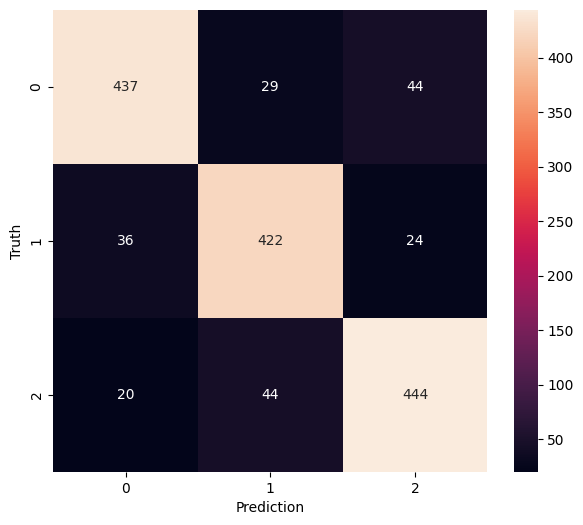

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,6))
sns.heatmap(cm , annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')